In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%cd ..
from src.test_bboxes import *

/repo


In [3]:
medsam_checkpoint = "weights/medsam/medsam_vit_b.pth"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
medsam_model = load_model(medsam_checkpoint, device)
medsam_model.eval()
print(f"MedSAM size: {sum(p.numel() for p in medsam_model.parameters())}")

MedSAM size: 93735472


In [4]:
tr_npy_path = "data/WORD/train_CT_Abd/"
val_npy_path = "data/WORD/val_CT_Abd/"
test_npy_path = "test_samples/"
batch_size = 2 

datamodule = NpyDataModule(
    tr_npy_path,
    val_npy_path,
    test_npy_path,
    batch_size=batch_size,
    num_workers=0,
    gt_in_ram=False,
)
datamodule.setup()

train size: 85921
val size: 17652
test size: 54


In [5]:
batch = next(iter(datamodule.test_dataloader()))

In [6]:
batch_bboxes = generate_bboxes(batch)
batch_bboxes

[[(686, 508, 760, 582)], [(210, 514, 282, 590)]]

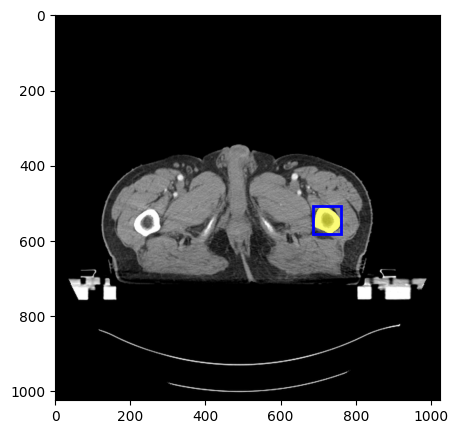

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(batch["image"][0].squeeze().detach().cpu().permute(1, 2, 0))
show_mask(batch["gt2D_orig"][0].squeeze().detach().cpu().numpy(), ax)
show_box(batch_bboxes[0][0], ax)

In [8]:
medsam_seg = infer_bboxes(batch, medsam_model, device)

In [9]:
medsam_seg.shape

torch.Size([2, 1024, 1024])

Dice: 0.94
Dice: 0.93


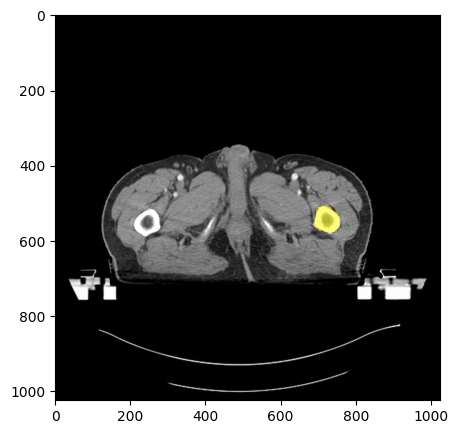

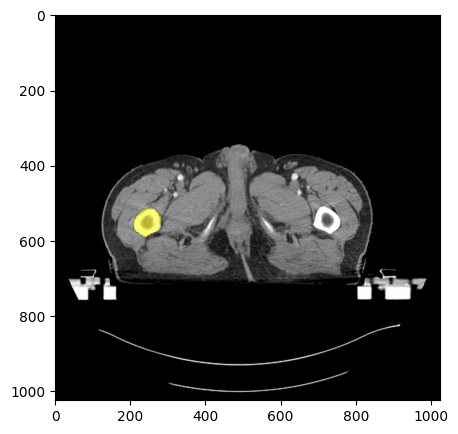

In [10]:
for i in range(batch_size):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(batch["image"][i].squeeze().detach().cpu().permute(1, 2, 0))
    show_mask(medsam_seg[i].detach().cpu().numpy(), ax)
    print(f"Dice: {round(dice(medsam_seg[i].detach().cpu().numpy(), batch["gt2D_orig"][i].squeeze().detach().cpu().numpy()), 2)}")